 ## Import the libraries

 ---

In [17]:
import pandas as pd
import numpy as np
from numpy import array

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# import chart_studio.plotly as py
import cufflinks as cf
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

# sklearn 
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LogisticRegression
from sklearn.metrics import confusion_matrix , precision_score, recall_score, f1_score, \
 roc_auc_score, accuracy_score, classification_report

import random

from yellowbrick.regressor import prediction_error

from imblearn.over_sampling import SMOTE

# tensorflow
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout ,BatchNormalization, LSTM, \
 RepeatVector, TimeDistributed, Flatten, SimpleRNN, GRU
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Bidirectional, GlobalMaxPool1D, Input, Embedding, Activation, \
 CuDNNLSTM, AveragePooling1D 
from keras.models import Model
from keras.callbacks import TensorBoard, Callback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.initializers import RandomNormal, Constant
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


## Loading & reading the data

---

In [18]:
df = pd.read_csv('/content/mkhdata.csv')

In [19]:
df

Unnamed: 0   city        date  ... humidity  barometer  visibility
0           94805  Mecca  2017-01-01  ...     69.0     1016.0          16
1           94806  Mecca  2017-01-01  ...     73.0     1015.0          16
2           94807  Mecca  2017-01-01  ...     73.0     1015.0          16
3           94808  Mecca  2017-01-01  ...     73.0     1015.0          16
4           94809  Mecca  2017-01-01  ...     73.0     1015.0          16
...           ...    ...         ...  ...      ...        ...         ...
20263      115068  Mecca  2019-04-30  ...     43.0     1009.0          16
20264      115069  Mecca  2019-04-30  ...     46.0     1009.0          16
20265      115070  Mecca  2019-04-30  ...     49.0     1010.0          16
20266      115071  Mecca  2019-04-30  ...     49.0     1010.0          16
20267      115072  Mecca  2019-04-30  ...     43.0     1010.0          16

[20268 rows x 15 columns]

In [46]:
df.describe()

year         month  ...       day_cos       day_sin
count  20268.000000  20268.000000  ...  2.026800e+04  2.026800e+04
mean    2017.710480      5.958309  ... -6.776244e-04 -2.045540e-04
std        0.698316      3.511464  ...  7.068519e-01  7.073961e-01
min     2017.000000      1.000000  ... -1.000000e+00 -1.000000e+00
25%     2017.000000      3.000000  ... -7.071068e-01 -7.071068e-01
50%     2018.000000      6.000000  ... -1.836970e-16  1.224647e-16
75%     2018.000000      9.000000  ...  7.071068e-01  7.071068e-01
max     2019.000000     12.000000  ...  1.000000e+00  1.000000e+00

[8 rows x 12 columns]

### Data Cleaning

In [20]:
# Unnamed: 0 is irrlevent 
delete_col =['Unnamed: 0']
df.drop(delete_col, axis =1 , inplace =True)

In [21]:
df.shape

(20268, 14)

In [22]:
# Converting the dt column to datetime object 
df['Datetime'] = pd.to_datetime(df['date'].apply(str)+' '+df['time'])
# Sorting by the date 
df.sort_values('Datetime', inplace=True)

In [38]:
# Features used in models
features = ['temp', 'humidity', 'barometer']

In [43]:
df[features].head()


temp  humidity  barometer
0    22      69.0     1016.0
1    21      73.0     1015.0
2    21      73.0     1015.0
3    21      73.0     1015.0
4    21      73.0     1015.0

In [45]:
df[['Datetime', 'temp']].head(10)

Datetime  temp
0 2017-01-01 00:00:00    22
1 2017-01-01 01:00:00    21
2 2017-01-01 02:00:00    21
3 2017-01-01 03:00:00    21
4 2017-01-01 04:00:00    21
5 2017-01-01 05:00:00    20
6 2017-01-01 06:00:00    20
7 2017-01-01 07:00:00    19
8 2017-01-01 08:00:00    20
9 2017-01-01 09:00:00    23

In [47]:
df.dtypes

city                  object
date                  object
time                  object
year                   int64
month                  int64
day                    int64
hour                   int64
minute                 int64
weather               object
temp                   int64
wind                   int64
humidity             float64
barometer            float64
visibility             int64
Datetime      datetime64[ns]
day_cos              float64
day_sin              float64
dtype: object

## EDA
---

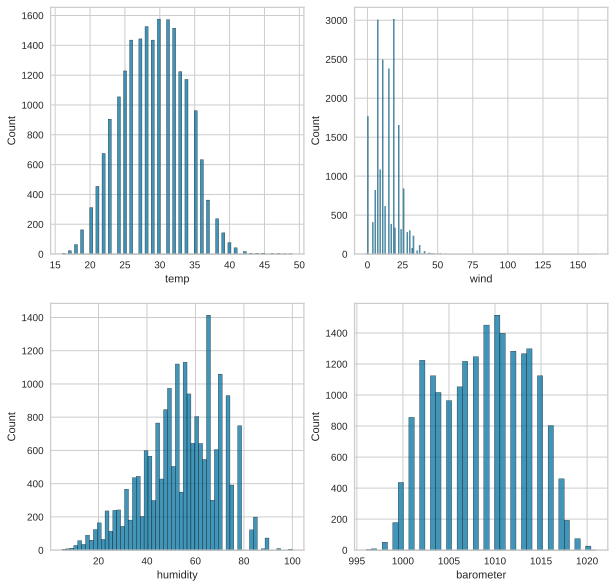

In [25]:
cols_to_plot = ['temp', 'wind', 'humidity', 'barometer']
plt.figure(figsize=(10, 10))
for i, col in enumerate(cols_to_plot):
    plt.subplot(2, 2, i+1)
    sns.histplot(data=df, x=col)

In [55]:
plot_features = df.groupby('date')[features].mean()

fig, axes = plt.subplots(
    nrows=2, 
    ncols=2, 
    figsize=(10, 8), 
    facecolor="w", 
    edgecolor="k"
)

for i, feature in enumerate(features):
    axes[i // 2, i % 2].plot(plot_features[feature])
    axes[i // 2, i % 2].set_title(f'{feature} Mecca - daily')
        
plt.tight_layout()

plt.show()

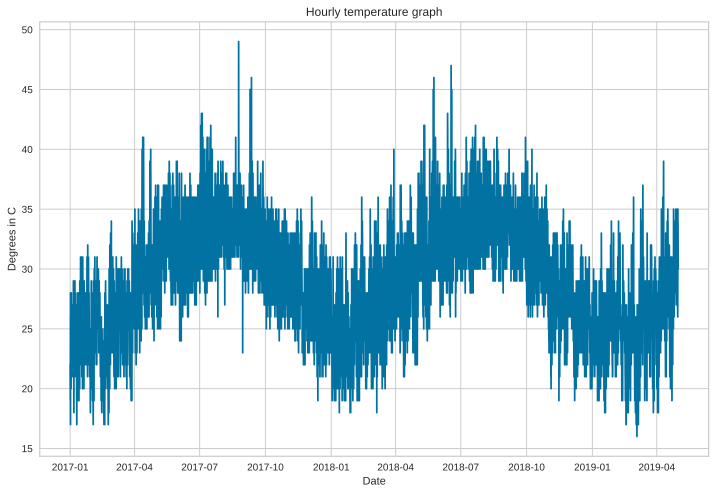

In [48]:
plt.figure(figsize=(12, 8))
plt.plot('Datetime', 'temp', data=df)
plt.title('Hourly temperature graph')
plt.ylabel('Degrees in C')
plt.xlabel('Date')
plt.show()

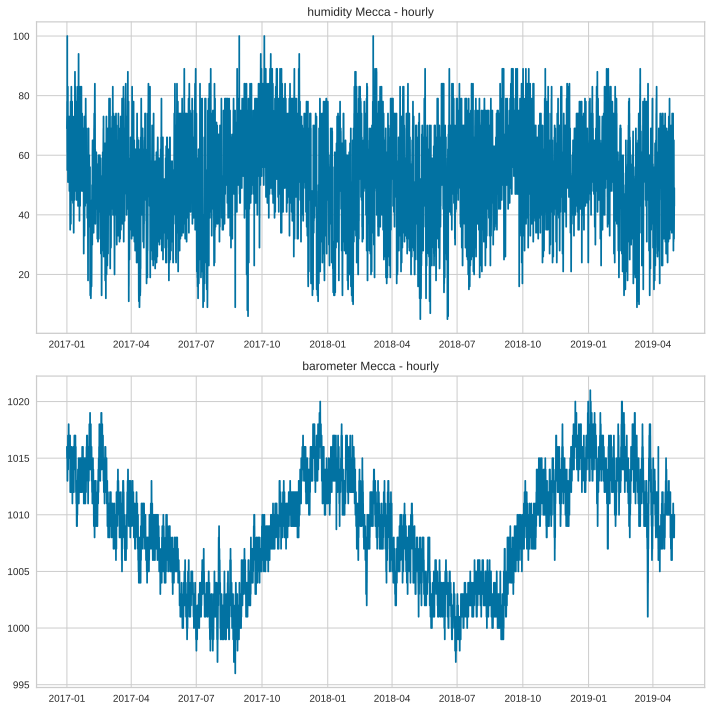

In [51]:
plot_features = df[features]
plot_features.index = df.Datetime

fig, axes = plt.subplots(
    nrows=2, 
    ncols=1, 
    figsize=(10, 10), 
    facecolor="w", 
    edgecolor="k"
)

for i, feature in enumerate(['humidity', 'barometer']):
    axes[i % 2].plot(plot_features[feature])
    axes[i % 2].set_title(f'{feature} Mecca - hourly')
        
plt.tight_layout()

plt.show()

### Heatmaps 

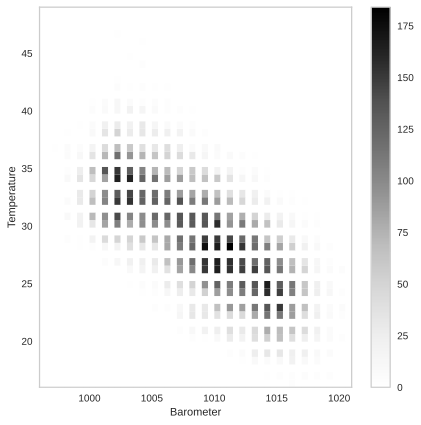

In [61]:
plt.figure(figsize=(7,7))
plt.hist2d(df['barometer'], df['temp'], bins=(50, 50))
plt.colorbar()
ax = plt.gca()
plt.xlabel('Barometer')
plt.ylabel('Temperature')
ax.axis('tight')
plt.show()

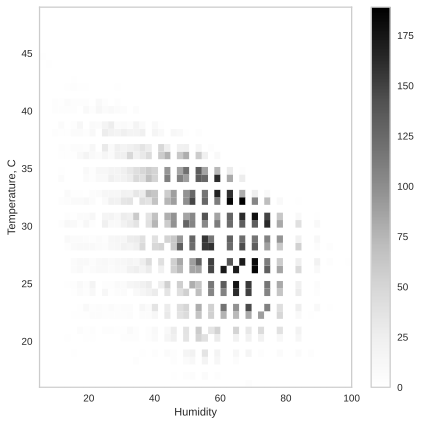

In [62]:
plt.figure(figsize=(7,7))
plt.hist2d(df['humidity'], df['temp'], bins=(50, 50))
plt.colorbar()
ax = plt.gca()
plt.xlabel('Humidity')
plt.ylabel('Temperature, C')
ax.axis('tight')
plt.show()

In [26]:
#df = pd.get_dummies(df)

In [11]:
#df

### Feature engineering 

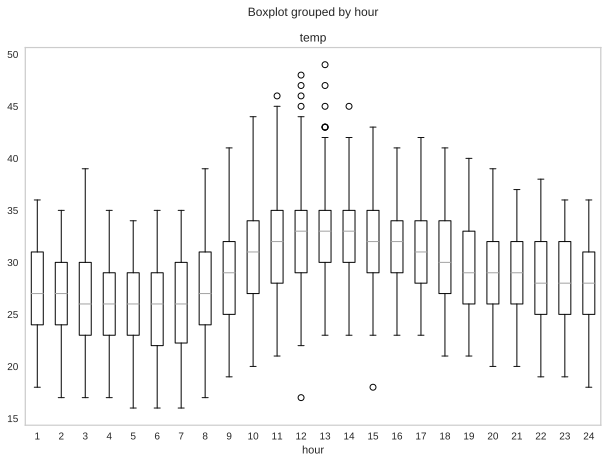

In [80]:
df.boxplot('temp', by='hour', figsize=(10,7), grid=False);

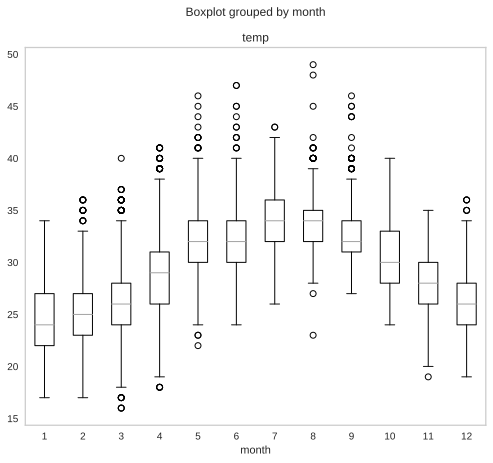

In [77]:
df.boxplot('temp', by='month', figsize=(8, 7), grid=False);

In [27]:
# Creating the cyclical daily feature 
df['day_cos'] = [np.cos(x * (2 * np.pi / 24)) for x in df['hour']]
df['day_sin'] = [np.sin(x * (2 * np.pi / 24)) for x in df['hour']]

In [28]:
dsin = df[['Datetime', 'temp', 'hour', 'day_sin', 'day_cos']].head(25).copy()
dsin['day_sin'] = [round(x, 3) for x in dsin['day_sin']]
dsin['day_cos'] = [round(x, 3) for x in dsin['day_cos']]

dsin

Datetime  temp  hour  day_sin  day_cos
0  2017-01-01 00:00:00    22    24   -0.000    1.000
1  2017-01-01 01:00:00    21     1    0.259    0.966
2  2017-01-01 02:00:00    21     2    0.500    0.866
3  2017-01-01 03:00:00    21     3    0.707    0.707
4  2017-01-01 04:00:00    21     4    0.866    0.500
5  2017-01-01 05:00:00    20     5    0.966    0.259
6  2017-01-01 06:00:00    20     6    1.000    0.000
7  2017-01-01 07:00:00    19     7    0.966   -0.259
8  2017-01-01 08:00:00    20     8    0.866   -0.500
9  2017-01-01 09:00:00    23     9    0.707   -0.707
10 2017-01-01 10:00:00    25    10    0.500   -0.866
11 2017-01-01 11:00:00    26    11    0.259   -0.966
12 2017-01-01 12:00:00    17    12    0.000   -1.000
13 2017-01-01 13:00:00    28    13   -0.259   -0.966
14 2017-01-01 14:00:00    27    14   -0.500   -0.866
15 2017-01-01 15:00:00    27    15   -0.707   -0.707
16 2017-01-01 16:00:00    26    16   -0.866   -0.500
17 2017-01-01 17:00:00    26    17   -0.966   -0.259
18 2017-01-01 18:00:00    25    18   -1.000   -0.000
19 2017-01-01 19:00:00    25    19   -0.966    0.259
20 2017-01-01 20:00:00    24    20   -0.866    0.500
21 2017-01-01 21:00:00    24    21   -0.707    0.707
22 2017-01-01 22:00:00    23    22   -0.500    0.866
23 2017-01-01 23:00:00    23    23   -0.259    0.966
24 2017-01-02 00:00:00    23    24   -0.000    1.000

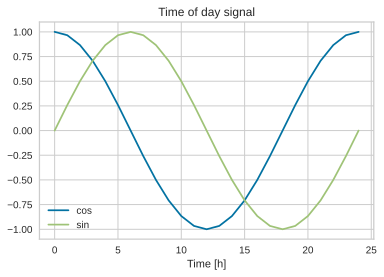

In [37]:
# Ploting the first 25 hours 
plt.plot(np.array(df['day_cos'])[:25], label='cos')
plt.plot(np.array(df['day_sin'])[:25], label='sin')
plt.xlabel('Time [h]')
plt.title('Time of day signal')
plt.legend()
plt.show()

## Split

---

In [33]:
df_Train, df_test = train_test_split(df, test_size=0.2, random_state= 30 , shuffle = False)

df_train, df_val = train_test_split(df_Train, test_size=0.2, random_state= 30 , shuffle = False)

## Scaler
---

In [63]:
#scaler = StandardScaler()

#df_train_scaled =scaler.fit_transform(df_train.values)
#df_val_scaled = scaler.transform(df_val.values)
#df_test_scaled = scaler.transform(df_test.values)

In [64]:
print(f'Shape of train:', df_train.shape)
print(f'Shape of validation:', df_val.shape)
print(f'Shape of test:', df_test.shape)

Shape of train: (12971, 17)
Shape of validation: (3243, 17)
Shape of test: (4054, 17)


### LinearRegression model

In [65]:
X_train = df_train.drop(["temp"], axis = 1)
y_train = df_train["temp"]
X_val= df_val.drop(['temp'], axis=1)
y_val= df_val['temp']
X_test= df_test.drop(['temp'], axis=1)
y_test= df_test['temp']

In [66]:
print("Length of the X_train = ",len(X_train))
print("Length of the y_train = ",len(y_train))
print("Length of the X_test = ",len(X_test))
print("Length of the y_test = ",len(y_test))
print("Length of the y_val = ",len(y_val))
print("Length of the y_val = ",len(y_val))

Length of the X_train =  12971
Length of the y_train =  12971
Length of the X_test =  4054
Length of the y_test =  4054
Length of the y_val =  3243
Length of the y_val =  3243


In [68]:
#lm = LinearRegression().fit(X_train,y_train)
#lm.score(X_train,y_train)

## LSTM Model
---

In [69]:
# Build the LSTM Stack model
model=Sequential()
#Adding first LSTM layer
model.add(LSTM(150,return_sequences=True,input_shape=(100,1)))
model.add(Dropout(0.2)) # Dropout regularisation
#second LSTM layer 
model.add(LSTM(150,return_sequences=True))
#Adding third LSTM layer 
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.2))
#Adding fourth LSTM layer
model.add(LSTM(150))
model.add(Dropout(0.2))
#Adding the Output Layer
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [70]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 150)          91200     
                                                                 
 dropout (Dropout)           (None, 100, 150)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 150)          180600    
                                                                 
 lstm_2 (LSTM)               (None, 100, 150)          180600    
                                                                 
 dropout_1 (Dropout)         (None, 100, 150)          0         
                                                                 
 lstm_3 (LSTM)               (None, 150)               180600    
                                                                 
 dropout_2 (Dropout)         (None, 150)               0

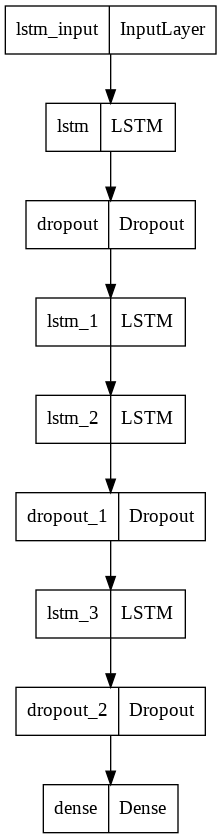

In [71]:
plot_model(model, to_file='model.png')


In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Reshape((100, 1), input_shape=(100,)))
# model.output_shape == (None, 100, 1), `None` is the batch size.
model.output_shape


(None, 100, 1)

In [ ]:
# #### EROR
# from tensorflow.keras.callbacks import EarlyStopping

# monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, 
#         verbose=1, mode='auto', restore_best_weights=True)

# history=model.fit(X_train,y_train,validation_data=(X_test,y_test),callbacks=[monitor],verbose=1,epochs=1000)


In [ ]:
#log_cfl = LogisticRegression(C=0.95, random_state=0)

#log_cfl.fit(X_train, y_train)

#y_predict = log_cfl.predict(X_train)

# evaluate the model
#print(classification_report(X_train, y_predict))
#print(confusion_matrix(X_train, y_predict))

In [ ]:
#regr = linear_model.Ridge(alpha= 0.5)
#regr.fit(X_train,y_train)

#y_pred = regr.predict(df_test)
#y_pred

## RNN 
---

In [ ]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)
filepath = "model.h5"
ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
rlp = ReduceLROnPlateau(monitor='loss', patience=3, verbose=1)

In [ ]:
n_input = (100,1)

In [ ]:
# error
train_generator = TimeseriesGenerator(df_train_scaled ,df_train_scaled, length=n_input, batch_size=32)

TypeError: ignored

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100, 64)           16896     
                                                                 
 lstm_5 (LSTM)               (None, 100, 32)           12416     
                                                                 
 lstm_6 (LSTM)               (None, 100, 16)           3136      
                                                                 
 lstm_7 (LSTM)               (None, 8)                 800       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 33,257
Trainable params: 33,257
Non-trainable params: 0
_________________________________________________________________


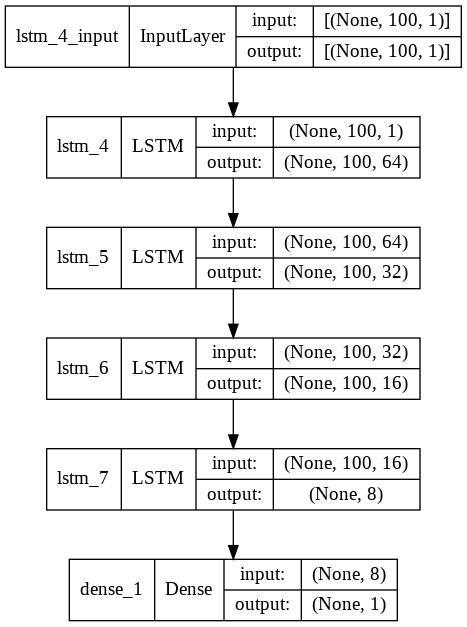

In [ ]:
model = Sequential()

model.add(LSTM(64, input_shape= ((100,1)), return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16, return_sequences=True))
model.add(LSTM(8, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()
plot_model(model, show_shapes=True)

In [ ]:
history = model.fit_generator(train_generator, callbacks=[es, ckpt, rlp], epochs=100)
pd.DataFrame(history.history)[['loss']].plot();

NameError: ignored

## CNN Model
---

In [ ]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_val.values.reshape((X_val.shape[0], X_val.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (12971, 961, 1)
Validation set shape (3243, 961, 1)


In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer='adam')
model_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 960, 64)           192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 480, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 30720)             0         
                                                                 
 dense_2 (Dense)             (None, 50)                1536050   
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,536,293
Trainable params: 1,536,293
Non-trainable params: 0
____________________________________________

In [ ]:
cnn_history = model_cnn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40, verbose=2)

Epoch 1/40
406/406 - 17s - loss: 29.1980 - val_loss: 9.1188 - 17s/epoch - 43ms/step
Epoch 2/40
406/406 - 16s - loss: 6.7178 - val_loss: 2.8622 - 16s/epoch - 40ms/step
Epoch 3/40
406/406 - 16s - loss: 3.7142 - val_loss: 1.6817 - 16s/epoch - 39ms/step
Epoch 4/40
406/406 - 16s - loss: 2.7632 - val_loss: 1.4903 - 16s/epoch - 40ms/step
Epoch 5/40
406/406 - 16s - loss: 3.2656 - val_loss: 1.6550 - 16s/epoch - 40ms/step
Epoch 6/40
406/406 - 16s - loss: 2.8933 - val_loss: 17.7998 - 16s/epoch - 39ms/step
Epoch 7/40
406/406 - 16s - loss: 2.4654 - val_loss: 1.5475 - 16s/epoch - 40ms/step
Epoch 8/40
406/406 - 16s - loss: 2.3491 - val_loss: 2.2312 - 16s/epoch - 40ms/step
Epoch 9/40
406/406 - 16s - loss: 2.2987 - val_loss: 1.1757 - 16s/epoch - 40ms/step
Epoch 10/40
406/406 - 16s - loss: 2.7038 - val_loss: 4.0535 - 16s/epoch - 39ms/step
Epoch 11/40
406/406 - 16s - loss: 1.9727 - val_loss: 1.1388 - 16s/epoch - 40ms/step
Epoch 12/40
406/406 - 16s - loss: 2.0463 - val_loss: 2.7861 - 16s/epoch - 40ms/step

## LSTM Model2

---

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer='adam')
model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 50)                10400     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_history = model_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, verbose=2)

Epoch 1/5
406/406 - 174s - loss: nan - val_loss: nan - 174s/epoch - 429ms/step
Epoch 2/5
406/406 - 171s - loss: nan - val_loss: nan - 171s/epoch - 420ms/step
Epoch 3/5
406/406 - 172s - loss: nan - val_loss: nan - 172s/epoch - 422ms/step
Epoch 4/5
406/406 - 175s - loss: nan - val_loss: nan - 175s/epoch - 431ms/step
Epoch 5/5
406/406 - 174s - loss: nan - val_loss: nan - 174s/epoch - 428ms/step


## CNN-LSTM 
---

In [ ]:
## error
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_sub = X_train.reshape((X_train.shape[0], subsequences, timesteps, 1))
X_val_sub = X_val.reshape((X_val_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_sub.shape)
print('Validation set shape', X_val_sub.shape)

AttributeError: ignored

In [ ]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_sub.shape[2], X_train_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer='adam')

NameError: ignored

In [ ]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_sub, y_train, validation_data=(X_val_sub, y_val), epochs=3, verbose=2)

## Bi-directional LSTM

Adding Bi-directional wrapper around LSTM

---

In [ ]:
es_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

def get_model_bilstm(shape=(19,22)):
    inp = Input(shape)
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(inp)
    x = TimeDistributed(Dense(10))(x)
    x = Flatten()(x)
    x = Dense(1)(x)
    model = Model(inp, x)
    return model

In [ ]:
model_bi = get_model_bilstm((19,22))
model_bi.compile(optimizer='adadelta', loss='mae')
model_bi.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 19, 22)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 19, 128)          45056     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 19, 10)           1290      
 ibuted)                                                         
                                                                 
 flatten_1 (Flatten)         (None, 190)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 191       
                                                                 
Total params: 46,537
Trainable params: 46,537
Non-trainable p

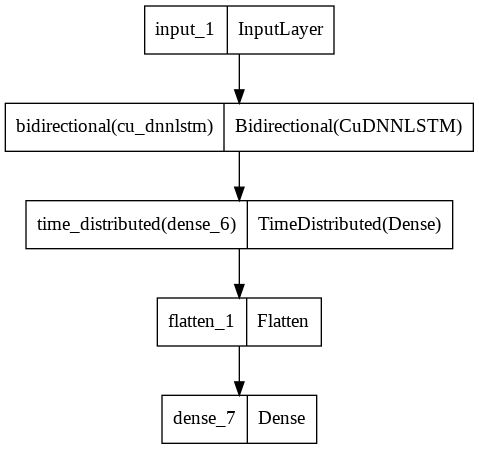

In [ ]:
plot_model(model_bi, to_file='model_bi1.png')

In [ ]:
 #model_bi.fit(X_train, y_train, validation_data=(X_val, y_val),
             # epochs=300, batch_size=128)

In [ ]:
# y_pred_bi = model_bi.predict(X_test)


In [ ]:
# submission_bi = pd.DataFrame({'Id': test_ids, 'Expected': y_pred_bi.reshape(-1)})
# submission_bi.to_csv('submission_2.csv', index=False)

In [ ]:
early_stop = EarlyStopping(monitor = "loss", mode = "min", patience = 7)
model_bi = Sequential()
model_bi.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(30,1)))
model_bi.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model_bi.add(MaxPooling1D(pool_size=2))
model_bi.add(Flatten())
model_bi.add(RepeatVector(30))
model_bi.add(LSTM(units=100, return_sequences=True, activation='relu'))
model_bi.add(Dropout(0.2))
model_bi.add(LSTM(units=100, return_sequences=True, activation='relu'))
model_bi.add(Dropout(0.2))
model_bi.add(LSTM(units=100, return_sequences=True, activation='relu'))
model_bi.add(LSTM(units=100, return_sequences=True, activation='relu'))
model_bi.add(Bidirectional(LSTM(128, activation='relu')))
model_bi.add(Dense(100, activation='relu'))
model_bi.add(Dense(1))
model_bi.compile(loss='mse', optimizer='adam')

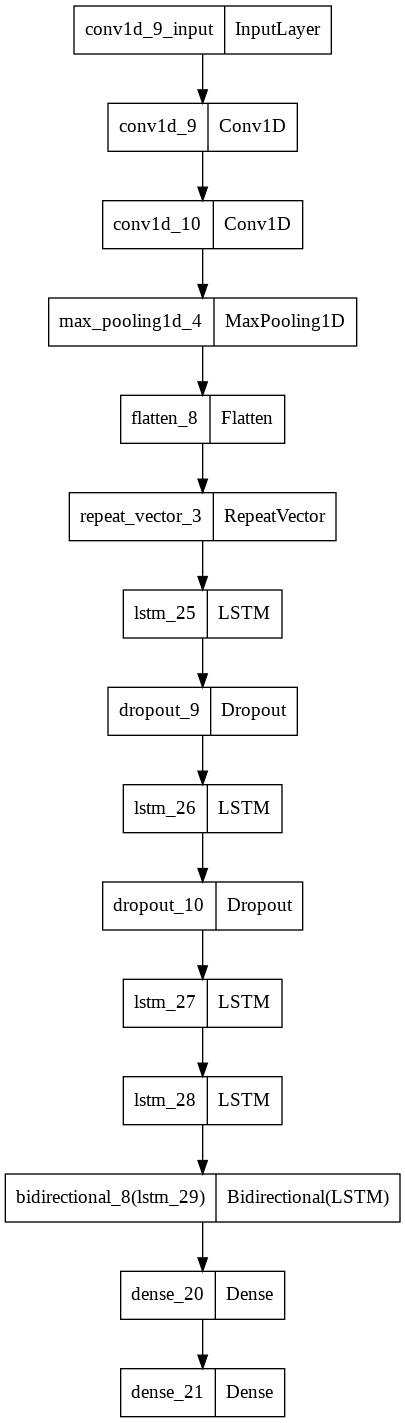

In [ ]:
plot_model(model_bi, to_file='model_bi2.png')

In [ ]:
# model_bi.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, verbose=2)

In [ ]:
# history = model_bi.fit(X_train,y_train, validation_data=(X_val, y_val), epochs=300, verbose=1, callbacks = [early_stop] )


In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence,n_steps):
    X,y = list(),list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_idx = i+n_steps
        # Check if we are beyond the sequence 
        if end_idx  > len(sequence)-1:
            break
        # gather i/o parts of the pattern
        seq_x,seq_y = sequence[i:end_idx],sequence[end_idx]
        X.append(seq_x)
        y.append(seq_y)
        
    return array(X),array(y)

# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print('Prediction score: ', yhat)

Prediction score:  [[102.04194]]


## Stacked-LSTM

In [ ]:
# LSTM are sensitive to the scale of the data,threfore applying MinMaxScaler
Scaler=MinMaxScaler(feature_range=(0,1))
df=Scaler.fit_transform(np.array(df).reshape(-1,1))
df

array([[9.99009901e-01],
       [9.90099010e-04],
       [9.90099010e-04],
       ...,
       [4.95049505e-04],
       [4.95049505e-04],
       [4.95049505e-04]])

In [ ]:
#splitting dataset into train and test split 
training_size = int(len(df)*0.70)
test_size = len(df)-training_size
train_data, test_data = df[0:training_size,:] ,df[training_size:len(df),:1]

In [ ]:
training_size, test_size

(13648471, 5849345)

In [ ]:
#convert an array of values into a dataset matrix
def create_dataset(dataset,time_step=1):
  datax, datay = [],[]
  for i in range(len(dataset)-time_step-1):
    a=dataset[i:(i+time_step),0] ##j=0, 0,1,2,3,4,....,99,100
    datax.append(a)
    datay.append(dataset[i+time_step,0])
    return np.array(datax),np.array(datay)

In [ ]:
#reshape into x=t, t+1, t+2, t+3 and y=t+4
time_step = 100
x_train,y_train = create_dataset(train_data,time_step)
x_test,ytest = create_dataset(test_data,time_step)

In [ ]:
print(x_train.shape),print(y_train.shape)

(1, 100)
(1,)


(None, None)

In [ ]:
print(x_test.shape),print(ytest.shape)

(1, 100)
(1,)


(None, None)

In [ ]:
#reshape input to be [samples,time-steps,feature] which is required for LSTM
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test= x_test.reshape(x_test.shape[0],x_test.shape[1],1)

Model Buildung 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
model = Sequential()
model.add(LSTM(50,return_sequences= True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_10 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


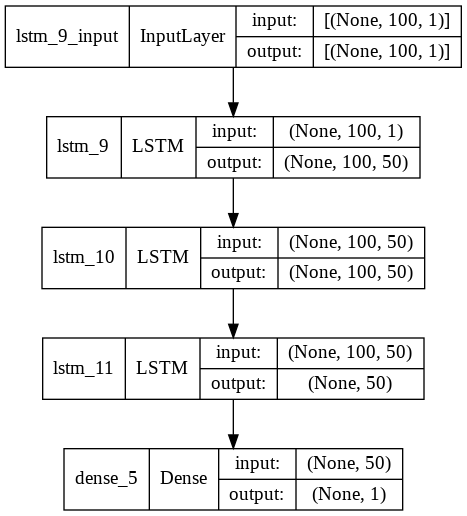

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
#model.fit(x_train, y_train, validation_data=(X_val, y_val), epochs=60, batch_size=64, verbose=1)

In [ ]:
#lets do the prediction and check performance metrics 
test_predict = model.predict(x_test)

In [ ]:
#transform back to original form
test_predict1 = Scaler.inverse_transform(test_predict)
test_predict1

array([[-1.0543398]], dtype=float32)

In [ ]:
# calculate RMSE performance metrics 
import math 
from sklearn.metrics import mean_squred_error
math.sqrt(mean_squared_error(ytest,test_predict))

ImportError: ignored

In [ ]:
#TRY another code 

In [ ]:
 def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [ ]:
n_past = 10
n_future = 5 
n_features = 7

In [ ]:
X_train, y_train = split_series(X_train_series,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [ ]:
# E1D1
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

#
model_e1d1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 7)]      0           []                               
                                                                                                  
 lstm_12 (LSTM)                 [(None, 100),        43200       ['input_2[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 repeat_vector (RepeatVector)   (None, 5, 100)       0           ['lstm_12[0][0]']                
                                                                                            

In [ ]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 10, 7)]      0           []                               
                                                                                                  
 lstm_14 (LSTM)                 [(None, 10, 100),    43200       ['input_3[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_15 (LSTM)                 [(None, 100),        80400       ['lstm_14[0][0]']                
                                 (None, 100),                                               

In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbos

SyntaxError: ignored

In [ ]:
pred_e1d1=model_e1d1.predict(X_test)
pred_e2d2=model_e2d2.predict(X_test)

In [ ]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    pred1_e1d1[:,:,index]=scaler.inverse_transform(pred1_e1d1[:,:,index])
    pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])
    pred1_e2d2[:,:,index]=scaler.inverse_transform(pred1_e2d2[:,:,index])
    pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

In [ ]:
from sklearn.metrics import mean_absolute_error
for index,i in enumerate(train_df.columns):
  print(i)
  for j in range(1,6):
    print("Weather ",j,":")
    print("MAE-E1D1 : ",mean_absolute_error(y_test[:,j-1,index],pred1_e1d1[:,j-1,index]),end=", ")
    print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index]))
  print()
  print()

In [ ]:
## EVERY THING IN COMMENTED CELL IN THIS SECTION HAVE AN ERROR 